In [4]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy import stats
import numpy as np
import pickle
import pprint # Pretty Printer!
import warnings
import statistics

In [5]:
obs_path = "C:/Users/ilebe/Documents/!Masters!/Analysis/0. Data/Processed/All Processed Final Location"
covariates_path = "C:/Users/ilebe/Documents/!Masters!/Analysis/0. Data/Processed/covariates"
get_rid_of_these_sites_retn_too_large = ["H23-RS-167", "H-RS-1-98", "H23-RS-109"]
mean_var_figure_path = r"C:\Users\ilebe\Documents\!Masters!\Analysis\AbundanceConditionalOccupancy\Output\Mean and variance"

# Prepare truncated dataframes

In [6]:
# load predictive dataframe from the playback model
precited_amps = pd.read_csv(r"C:\Users\ilebe\Documents\!Masters!\Playback analysis\0. Data\Processed\real data\predicted_distance_amplitudes.csv")
data_to_truncate = pd.read_csv(r"C:\Users\ilebe\Documents\!Masters!\Analysis\0. Data\Processed\All Processed Final Location\ready_to_truncate.csv")

| Target species  | Reference |
|------|-------|
| WTSP | VESP  |
| RCKI | AMRO  |
| TEWA | AMRO  |
| OSFL | WEME  |
| YRWA | CCSP  |
| REVI | BRBL  |


In [10]:
# WTSP: VESP, RCKI: AMRO, TEWA: AMRO, OSFL: WEME, YRWA: CCSP, REVI: BRBL

In [7]:
# make a function that identifies the amplitude at which to truncate in forest and open for each bird.
spp_dict = {
    "WTSP": "VESP",
    "RCKI": "AMRO",
    "TEWA": "AMRO",
    "OSFL": "WEME",
    "YRWA": "CCSP",
    "REVI": "BRBL"
}

# Assuming df is your DataFrame and 'predicted' is a column in your DataFrame
# We'll create a function that applies the mapping based on your dictionary

def map_spp(reference_spp):
    for key, value in spp_dict.items():
        if reference_spp == value:
            return key
    return None  # Return None or any default value you prefer if no match is found

# Now, apply this function to create a new column in your DataFrame
precited_amps['spp'] = precited_amps['species_code'].apply(map_spp)


In [9]:
precited_amps.drop('Unnamed: 0', axis = 1, inplace=True)

In [29]:
precited_amps[precited_amps['spp'] == 'RCKI']

,distance,species_code,BinForest,predicted,spp
1200,15.000000,AMRO,FO,-11.125139,RCKI
1201,15.953177,AMRO,FO,-11.723749,RCKI
1202,16.906355,AMRO,FO,-12.291296,RCKI
1203,17.859532,AMRO,FO,-12.831189,RCKI
1204,18.812709,AMRO,FO,-13.346306,RCKI
...,...,...,...,...,...
2995,296.187291,AMRO,OP,-47.710457,RCKI
2996,297.140468,AMRO,OP,-47.769168,RCKI
2997,298.093645,AMRO,OP,-47.827789,RCKI
2998,299.046823,AMRO,OP,-47.886321,RCKI


make a dicionary of dictionaries where the key is the distance in interger and the value is the the dictionary of the open and forested amps at which to truncate at that distance 

In [10]:
# TEWA and RCI are the same, so use RCKI fro the TEWA part
species_of_interest = ['RCKI', 'WTSP', 'YRWA', 'REVI', 'OSFL']

# Filter DataFrames for 'BinForest' conditions
df_op = precited_amps[precited_amps['BinForest'] == 'OP']
df_fo = precited_amps[precited_amps['BinForest'] == 'FO']

# Initialize the main dictionary
distance_dict = {}

for distance in range(30, 301):  # 300 inclusive
    distance_dict[distance] = {}
    for species in species_of_interest:
        # Initialize the list for this species with default None values
        distance_dict[distance][species] = [None, None]
        
        # Find the closest 'OP' row for this species and distance
        op_rows = df_op[df_op['spp'] == species]
        if not op_rows.empty:
            closest_op_row = op_rows.iloc[(op_rows['distance']-distance).abs().argsort()[:1]]
            closest_op_distance = closest_op_row['distance'].values[0]
            if abs(closest_op_distance - distance) <= 1:  # Adjust tolerance as needed
                distance_dict[distance][species][0] = closest_op_row['predicted'].values[0]
        
        # Find the closest 'FO' row for this species and distance
        fo_rows = df_fo[df_fo['spp'] == species]
        if not fo_rows.empty:
            closest_fo_row = fo_rows.iloc[(fo_rows['distance']-distance).abs().argsort()[:1]]
            closest_fo_distance = closest_fo_row['distance'].values[0]
            if abs(closest_fo_distance - distance) <= 1:  # Adjust tolerance as needed
                distance_dict[distance][species][1] = closest_fo_row['predicted'].values[0]

# Add TEWA
for distance, species_dict in distance_dict.items():
    # Check if 'RCKI' is a key in the current dictionary
    if 'RCKI' in species_dict:
        # Duplicate the 'RCKI' item under the new key 'TEWA'
        species_dict['TEWA'] = species_dict['RCKI']


In [14]:
# Transforming the data into a multi-level column DataFrame
# First, prepare the data
formatted_data = []
for distance, birds in distance_dict.items():
    row = {"Distance": distance}
    for bird, values in birds.items():
        row[(bird, "FO")] = values[0]
        row[(bird, "OP")] = values[1]
    formatted_data.append(row)

# Create a DataFrame
df = pd.DataFrame(formatted_data)
df.set_index("Distance", inplace=True)

# Adjusting the column levels
df.columns = pd.MultiIndex.from_tuples(df.columns, names=["Bird", "Forest"])

df

Bird           RCKI                  WTSP                  YRWA              
Forest           FO         OP         FO         OP         FO         OP   
Distance                                                                     
30       -19.299942 -18.233924 -22.016036 -20.950018 -27.356232 -26.290214  \
31       -19.600206 -18.566877 -22.316300 -21.282971 -27.656496 -26.623167   
32       -19.892362 -18.891721 -22.608456 -21.607815 -27.948651 -26.948011   
33       -20.176882 -19.208931 -22.892976 -21.925025 -28.233172 -27.265220   
34       -20.454202 -19.518939 -23.170296 -22.235033 -28.510492 -27.575229   
...             ...        ...        ...        ...        ...        ...   
296      -47.710457 -55.764610 -50.426551 -58.480704 -55.766747 -63.820900   
297      -47.769168 -55.856009 -50.485262 -58.572103 -55.825457 -63.912299   
298      -47.827789 -55.947319 -50.543883 -58.663413 -55.884078 -64.003609   
299      -47.886321 -56.038540 -50.602415 -58.754634 -55.942611 -64.094830   
300      -47.944765 -56.129673 -50.660859 -58.845767 -56.001054 -64.185962   

Bird           REVI                  OSFL                  TEWA             
Forest           FO         OP         FO         OP         FO         OP  
Distance                                                                    
30       -22.306379 -21.240360 -19.321515 -18.255497 -19.299942 -18.233924  
31       -22.606643 -21.573313 -19.621779 -18.588449 -19.600206 -18.566877  
32       -22.898798 -21.898158 -19.913934 -18.913294 -19.892362 -18.891721  
33       -23.183319 -22.215367 -20.198455 -19.230503 -20.176882 -19.208931  
34       -23.460638 -22.525375 -20.475774 -19.540511 -20.454202 -19.518939  
...             ...        ...        ...        ...        ...        ...  
296      -50.716894 -58.771047 -47.732030 -55.786183 -47.710457 -55.764610  
297      -50.775604 -58.862446 -47.790740 -55.877582 -47.769168 -55.856009  
298      -50.834225 -58.953756 -47.849361 -55.968892 -47.827789 -55.947319  
299      -50.892757 -59.044977 -47.907893 -56.060113 -47.886321 -56.038540  
300      -50.951201 -59.136109 -47.966337 -56.151245 -47.944765 -56.129673  

[271 rows x 12 columns]

In [16]:
df.to_csv(os.path.join(mean_var_figure_path, 'distance_predictve_df.csv'))

In [9]:
# Make a dict like this one:

# bird: [open, forested]
dict_100m = {'REVI': [-33.47727, -34.41656],
            'OSFL': [-30.40729, -31.34658],
            'WTSP': [-33.02465, -33.96394],
            'YRWA': [-38.65988, -39.59917],
            'RCKI': [-30.48088, -31.42017],
            'TEWA': [-30.48088, -31.42017]}

# bird: [open, forested]
dict_150m = {'REVI': [-40.07877, -41.03906],
            'OSFL': [-37.00472, -37.96502],
            'WTSP': [-39.62246, -40.58276],
            'YRWA': [-45.27004, -46.23034],
            'RCKI': [-37.07850, -38.03879],
            'TEWA': [-37.07850, -38.03879]}

# bird: [open, forested]
dict_250m = {'REVI': [-50.61214, -51.57243],
            'OSFL': [-47.53809, -48.49839],
            'WTSP': [-50.15583, -51.11613],
            'YRWA': [-55.80341, -56.76371],
            'RCKI': [-47.61186, -48.57216],
            'TEWA': [-47.61186, -48.57216]}

In [34]:

def filter_dataframes_by_distance(dataframe, distance_dicts):
    # Dictionary to store each distance's filtered dataframe
    filtered_dfs = {}
    
    for distance in range(30, 301):  # Iterate through distances 30-300
        filter_dict = distance_dicts.get(distance)
        if filter_dict is not None:  # Check if there's a filter dict for the current distance
            all_filtered_rows = []  # List to store filtered rows for this distance
            for species, values in filter_dict.items():
                # Assuming the correct conditions based on your description
                condition_1 = (dataframe['species_code'] == species) & (dataframe['Year_since_logging'] < 11) & (dataframe['mean_amp'] >= values[0])  # OP
                condition_2 = (dataframe['species_code'] == species) & (dataframe['Year_since_logging'] >= 12) & (dataframe['mean_amp'] >= values[1])  # FO
                
                # Collect the filtered rows
                filtered_rows = dataframe[condition_1 | condition_2]
                all_filtered_rows.append(filtered_rows)
            
            # Concatenate all filtered rows for this distance into a single DataFrame
            filtered_df = pd.concat(all_filtered_rows, ignore_index=True)
            
            # Store the filtered dataframe in the dictionary with the distance as key
            filtered_dfs[distance] = filtered_df
    
    return filtered_dfs

# Example usage
# Assuming `data_to_truncate` is your original DataFrame and `distance_dicts` is your dictionary of dictionaries
filtered_dfs = filter_dataframes_by_distance(data_to_truncate, distance_dict)

# Accessing a specific filtered DataFrame, e.g., for 150 meters
filtered_df_50m = filtered_dfs[30]

In [35]:
filtered_dfs[30]

,location,recording_date_time,species_code,Year_since_logging,mean_amp
0,H22-CC-10,2022-06-27 06:39:00,WTSP,5,-18.080
1,H22-CC-10,2022-06-28 06:25:00,WTSP,5,-20.745
2,H22-CC-10,2022-06-28 06:40:00,WTSP,5,-15.485
3,H22-CC-10,2022-06-29 06:41:00,WTSP,5,-19.665
4,H22-CC-15,2022-06-29 05:41:00,WTSP,5,-15.160
...,...,...,...,...,...
221,H23-RS-215,2023-06-26 06:50:00,TEWA,12,-17.000
222,H23-RS-231,2023-06-17 07:18:00,TEWA,21,-8.380
223,H23-RS-231,2023-06-17 07:33:00,TEWA,21,-14.845
224,H23-RS-231,2023-06-21 09:18:00,TEWA,21,-16.740


In [20]:
filtered_df_50m
filtered_df_50m.to_csv(os.path.join(obs_path, 'Truncated_50m_count_per_site_filtered'))

,location,recording_date_time,species_code,Year_since_logging,mean_amp
0,H-RS-1-53N,2022-06-12 05:18:00,RCKI,18,-18.810
1,H-RS-1-93N,2022-06-06 05:24:00,RCKI,17,-22.255
2,H-RS-1-93N,2022-06-06 05:54:00,RCKI,17,-22.585
3,RETNO-1-51,2019-05-29 05:52:00,RCKI,0,-23.395
4,H22-CC-10,2022-06-26 06:39:00,WTSP,5,-25.675
...,...,...,...,...,...
564,H23-RS-224,2023-06-02 06:28:00,TEWA,2,-23.535
565,H23-RS-231,2023-06-17 07:18:00,TEWA,21,-8.380
566,H23-RS-231,2023-06-17 07:33:00,TEWA,21,-14.845
567,H23-RS-231,2023-06-21 09:18:00,TEWA,21,-16.740


In [ ]:
def sanity_check(dataframe, filter_dict):
    # Iterate over each species and its threshold values in the filter dictionary
    for species, values in filter_dict.items():
        # Extract rows corresponding to the current species
        species_df = dataframe[dataframe['species_code'] == species]
        
        # Check for rows that do not meet the filter conditions
        invalid_rows_1 = species_df[(species_df['Year_since_logging'] < 11) & (species_df['left_freq_filter_tag_peak_level_dbfs'] < values[0])]
        invalid_rows_2 = species_df[(species_df['Year_since_logging'] >= 12) & (species_df['left_freq_filter_tag_peak_level_dbfs'] < values[1])]
        
        # If any invalid rows are found, return a failure message with details
        if not invalid_rows_1.empty or not invalid_rows_2.empty:
            return f"Sanity check failed for species {species}. Check the filter conditions and data."
    
    # If all checks pass
    return "Sanity check passed! The filtered dataframe meets the conditions."

# Run the sanity check on the filtered dataframe
sanity_check_result = sanity_check(filtered_df_truncated_150m, dict_150m)
sanity_check_result


In [21]:
transcribed_tasks_all = pd.read_csv(r"C:\Users\ilebe\Documents\!Masters!\Analysis\0. Data\Processed\All Processed Final Location\transcribed_tasks_all.csv")


In [23]:
species_of_interest = ['TEWA', 'RCKI', 'WTSP', 'YRWA', 'REVI', 'OSFL']

transcribed_tasks_all = pd.read_csv(r"C:\Users\ilebe\Documents\!Masters!\Analysis\0. Data\Processed\All Processed Final Location\transcribed_tasks_all.csv")

# Group by 'location', 'recording_date_time', and 'species_code', and count the number of times each species appears
grouped_all_df = filtered_dfs[50].groupby(['location', 'recording_date_time', 'species_code']).size().reset_index(name='count')

# Pivot the dataframe to have one row per site per visit and columns for each species
pivot_all_df = grouped_all_df.pivot_table(index=['location', 'recording_date_time'], columns='species_code', values='count', fill_value=0).reset_index()

# Filter the columns to include only the species of interest and fill NaN values with 0
pivot_all_df = pivot_all_df[['location', 'recording_date_time'] + species_of_interest].fillna(0)

# Check which combinations from transcribed_tasks_all are not present in pivot_all_df
combinations_not_found = transcribed_tasks_all[~transcribed_tasks_all[['location', 'recording_date_time']].apply(tuple, axis=1).isin(pivot_all_df[['location', 'recording_date_time']].apply(tuple, axis=1))]

# Display the unique combinations that are not found
unique_combinations_not_found = combinations_not_found[['location', 'recording_date_time']].drop_duplicates()

# Keeo inlty the site+visits that are properlytranscribed
count_per_site_transcriber_not_filtered = pivot_all_df.copy(deep=True)

# Create a set of unique location+recording_date_time combinations from transcribed_tasks_all.csv
unique_transcribed_combinations = set(transcribed_tasks_all[['location', 'recording_date_time']].apply(tuple, axis=1))

# Filter the count_per_site_transcriber_not_filtered dataframe based on the unique combinations
filtered_count_per_site = count_per_site_transcriber_not_filtered[count_per_site_transcriber_not_filtered[['location', 'recording_date_time']].apply(tuple, axis=1).isin(unique_transcribed_combinations)]

# Step 4: Identify and add missing site-visit combinations
transcribed_combinations = set(transcribed_tasks_all[['location', 'recording_date_time']].apply(tuple, axis=1))
existing_combinations = set(filtered_count_per_site[['location', 'recording_date_time']].apply(tuple, axis=1))
missing_combinations = transcribed_combinations - existing_combinations
missing_combinations_df = pd.DataFrame(list(missing_combinations), columns=['location', 'recording_date_time'])
for species in species_of_interest:
    missing_combinations_df[species] = 0
updated_pivot_df = pd.concat([filtered_count_per_site, missing_combinations_df], ignore_index=True)

# Step 5: Filter the updated pivot table
final_filtered_pivot_df = updated_pivot_df[updated_pivot_df[['location', 'recording_date_time']].apply(tuple, axis=1).isin(transcribed_combinations)]

In [28]:
final_filtered_pivot_df[final_filtered_pivot_df['location'] == 'H-RS-1-53N']

,location,recording_date_time,TEWA,RCKI,WTSP,YRWA,REVI,OSFL
43,H-RS-1-53N,2022-06-10 05:49:00,0,0,1,0,0,0
44,H-RS-1-53N,2022-06-12 05:18:00,0,1,0,0,0,0
45,H-RS-1-53N,2022-06-12 06:18:00,0,0,1,0,0,0
46,H-RS-1-53N,2022-06-18 06:32:00,0,0,1,0,0,0
1120,H-RS-1-53N,2022-06-10 05:19:00,0,0,0,0,0,0
1532,H-RS-1-53N,2022-06-13 07:03:00,0,0,0,0,0,0
2145,H-RS-1-53N,2022-06-15 05:47:00,0,0,0,0,0,0
2639,H-RS-1-53N,2022-06-13 05:48:00,0,0,0,0,0,0
3130,H-RS-1-53N,2022-06-11 06:33:00,0,0,0,0,0,0
3946,H-RS-1-53N,2022-06-16 06:32:00,0,0,0,0,0,0


In [22]:
species_of_interest = ['TEWA', 'RCKI', 'WTSP', 'YRWA', 'REVI', 'OSFL']

In [25]:
final_filtered_pivot_df

,location,recording_date_time,TEWA,RCKI,WTSP,YRWA,REVI,OSFL
0,FMX-2-18-2,2020-06-18 07:20:00,0,0,1,0,0,0
1,H-CC-1-101,2022-06-07 05:20:00,0,0,1,0,0,0
2,H-CC-1-115N,2022-06-19 06:17:00,0,0,1,0,0,0
3,H-CC-1-115N,2022-06-23 05:48:00,0,0,1,0,0,0
4,H-CC-1-44N,2022-06-22 08:55:00,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...
6243,OG-37-128-B,2015-06-27 07:00:00,0,0,0,0,0,0
6244,H22-RS-25,2022-06-12 05:26:00,0,0,0,0,0,0
6245,H-RS-1-34,2022-06-22 06:40:00,0,0,0,0,0,0
6246,H22-RS-126,2022-06-13 07:07:00,0,0,0,0,0,0


In [52]:

def process_dataframe(df, species_of_interest, transcribed_tasks_all):
    # Group by 'location', 'recording_date_time', and 'species_code', and count the number of times each species appears
    grouped_df = df.groupby(['location', 'recording_date_time', 'species_code']).size().reset_index(name='count')

    # Pivot the dataframe to have one row per site per visit and columns for each species
    pivot_df = grouped_df.pivot_table(index=['location', 'recording_date_time'], columns='species_code', values='count', fill_value=0).reset_index()
    # print(pivot_df.columns)

    species_present = list(pivot_df.columns)[2:]
    # print(species_present)
    # Filter the pivot_df columns to include only the species of interest and fill NaN values with 0
    pivot_df = pivot_df[['location', 'recording_date_time'] + species_present].fillna(0)

    # Check which combinations from transcribed_tasks_all are not present in pivot_df
    combinations_not_found = transcribed_tasks_all[~transcribed_tasks_all[['location', 'recording_date_time']].apply(tuple, axis=1).isin(pivot_df[['location', 'recording_date_time']].apply(tuple, axis=1))]
    unique_combinations_not_found = combinations_not_found[['location', 'recording_date_time']].drop_duplicates()

    # Create a set of unique location+recording_date_time combinations from transcribed_tasks_all
    unique_transcribed_combinations = set(transcribed_tasks_all[['location', 'recording_date_time']].apply(tuple, axis=1))

    # Filter the pivot_df dataframe based on the unique combinations
    filtered_count_per_site = pivot_df[pivot_df[['location', 'recording_date_time']].apply(tuple, axis=1).isin(unique_transcribed_combinations)]

    # Identify and add missing site-visit combinations
    transcribed_combinations = set(filtered_count_per_site[['location', 'recording_date_time']].apply(tuple, axis=1))
    existing_combinations = set(filtered_count_per_site[['location', 'recording_date_time']].apply(tuple, axis=1))
    missing_combinations = transcribed_combinations - existing_combinations
    missing_combinations_df = pd.DataFrame(list(missing_combinations), columns=['location', 'recording_date_time'])
    for species in species_of_interest:
        missing_combinations_df[species] = 0
    updated_pivot_df = pd.concat([filtered_count_per_site, missing_combinations_df], ignore_index=True)

    # Filter the updated pivot table
    final_filtered_pivot_df = updated_pivot_df[updated_pivot_df[['location', 'recording_date_time']].apply(tuple, axis=1).isin(transcribed_combinations)]

    number_of_visits_per_site = pd.read_csv(os.path.join(obs_path, "number_of_transcribed_recordings_per_site.csv"))
    list_of_sites_to_use = number_of_visits_per_site[number_of_visits_per_site['number_of_visits'] >= 10]['location'].to_list()

    list_of_sites_to_use.remove("H23-RS-167")
    list_of_sites_to_use.remove("H-RS-1-98")
    list_of_sites_to_use.remove("H23-RS-109")
    
    final_filtered_pivot_df = final_filtered_pivot_df[final_filtered_pivot_df['location'].isin(list_of_sites_to_use)]


    return final_filtered_pivot_df

# Assuming filtered_dfs is your dictionary of DataFrames
processed_dfs = {}
for distance, df in filtered_dfs.items():
    # print(distance)
    processed_dfs[distance] = process_dataframe(df, species_of_interest, transcribed_tasks_all)

In [49]:
processed_dfs[300]

,location,recording_date_time,OSFL,RCKI,REVI,TEWA,WTSP,YRWA
0,AM-429-NW,2014-05-15 07:00:00,0,0,0,0,2,0
1,AM-429-NW,2014-05-15 08:00:00,0,0,0,0,2,0
2,AM-429-NW,2014-05-16 06:00:00,0,0,0,0,6,0
3,AM-429-NW,2014-05-17 06:00:00,0,0,0,0,3,0
4,AM-429-NW,2014-05-17 09:00:00,0,0,0,0,4,0
...,...,...,...,...,...,...,...,...
4460,STB-2-3,2019-06-04 07:58:00,0,0,0,1,2,0
4461,STB-2-3,2019-06-05 05:28:00,0,0,0,2,1,0
4462,STB-2-3,2019-06-05 05:58:00,0,0,0,2,0,0
4463,STB-2-3,2019-06-05 06:58:00,0,0,0,4,0,0


In [3]:
# truncated_100m_counts = pd.read_csv(os.path.join(obs_path, "Truncated_100m_count_per_site_filtered.csv"))
# truncated_100m_counts = pd.read_csv(os.path.join(obs_path, "Truncated_100m_count_per_site_filtered FIXED.csv"))
# truncated_150m_counts = pd.read_csv(os.path.join(obs_path, "Truncated_150m_count_per_site_filtered FIXED.csv"))
# truncated_250m_counts = pd.read_csv(os.path.join(obs_path, "Truncated_250m_count_per_site_filtered FIXED.csv"))
# counts = pd.read_csv(os.path.join(obs_path, "count_per_site_filtered.csv")) # this is unlimited

In [50]:
number_of_visits_per_site = pd.read_csv(os.path.join(obs_path, "number_of_transcribed_recordings_per_site.csv"))
list_of_sites_to_use = number_of_visits_per_site[number_of_visits_per_site['number_of_visits'] >= 10]['location'].to_list()

list_of_sites_to_use.remove("H23-RS-167")
list_of_sites_to_use.remove("H-RS-1-98")
list_of_sites_to_use.remove("H23-RS-109")

In [51]:
number_of_visits_per_site

,location,number_of_visits
0,H-CC-2-13,3
1,H22-RS-84,7
2,H-RS-6-53,8
3,H-RS-2-8,9
4,H-RS-6-14,9
...,...,...
395,H-CC-1-26,22
396,H-CC-1-57N,23
397,H-RS-1-32N,25
398,H-STUMP-1-2,29


In [5]:
warnings.filterwarnings('ignore')
truncCounts250_10vis = truncated_250m_counts[truncated_250m_counts['location'].isin(list_of_sites_to_use)]
truncCounts250_10vis.sort_values('location', inplace=True)

truncCounts150_10vis = truncated_150m_counts[truncated_150m_counts['location'].isin(list_of_sites_to_use)]
truncCounts150_10vis.sort_values('location', inplace=True)

truncCounts100_10vis = truncated_100m_counts[truncated_100m_counts['location'].isin(list_of_sites_to_use)]
truncCounts100_10vis.sort_values('location', inplace=True)

unlimitedCounts_10vis = counts[counts['location'].isin(list_of_sites_to_use)]
unlimitedCounts_10vis.sort_values('location', inplace=True)

# A. Mean to variance ratio

In [94]:
def get_max_count(dataframe, bird):
    obs_count_10 = dataframe 
    sites_with_10_or_more_visits = obs_count_10['location'].value_counts() >= 10
    sites_to_consider = sites_with_10_or_more_visits[sites_with_10_or_more_visits].index

    filtered_obs_count = obs_count_10[obs_count_10['location'].isin(sites_to_consider)]

    # Subsample to exactly 10 visits per site
    final_obs_count = filtered_obs_count.groupby('location').apply(lambda x: x.sample(n=10, replace=False, random_state = 123)).reset_index(drop=True)
    final_obs_count['visit_number'] = final_obs_count.groupby('location').cumcount() + 1
    N_matrix_visit_num = final_obs_count.pivot(index='location', columns='visit_number', values=f"{bird}").fillna(0).astype(int).values.tolist()

    # Calculate the maximum count encountered at each site
    max_counts = [max(site_counts) for site_counts in N_matrix_visit_num]
    return max_counts

dist_dict = processed_dfs
bird = 'YRWA'
bird_mean_var_dict = {}
for distance, dist_df in dist_dict.items():

    mean = statistics.mean(get_max_count(dist_df, bird))
    variance = statistics.variance(get_max_count(dist_df, bird))
    if mean != 0 and variance != 0:
        ratio = mean/variance
        bird_mean_var_dict[distance] = [mean, variance, ratio]


YRWA_mean_var_df = pd.DataFrame.from_dict(bird_mean_var_dict, orient = 'index', columns = ['mean', 'variance', 'ratio'])

In [6]:
def get_max_count(dataframe, bird):
    obs_count_10 = dataframe 
    sites_with_10_or_more_visits = obs_count_10['location'].value_counts() >= 10
    sites_to_consider = sites_with_10_or_more_visits[sites_with_10_or_more_visits].index

    filtered_obs_count = obs_count_10[obs_count_10['location'].isin(sites_to_consider)]

    # Subsample to exactly 10 visits per site
    final_obs_count = filtered_obs_count.groupby('location').apply(lambda x: x.sample(n=10, replace=False, random_state = 123)).reset_index(drop=True)
    final_obs_count['visit_number'] = final_obs_count.groupby('location').cumcount() + 1
    N_matrix_visit_num = final_obs_count.pivot(index='location', columns='visit_number', values=f"{bird}").fillna(0).astype(int).values.tolist()

    # Calculate the maximum count encountered at each site
    max_counts = [max(site_counts) for site_counts in N_matrix_visit_num]
    return max_counts

dist_dict = {'100m': truncCounts100_10vis, '150m': truncCounts150_10vis, '250m': truncCounts250_10vis, 'unlimited': unlimitedCounts_10vis}
dist_list = [truncCounts100_10vis, truncCounts150_10vis, truncCounts250_10vis, unlimitedCounts_10vis]

OSFL_mean_var_dict = {}
for distance, dist_df in dist_dict.items():
    mean = statistics.mean(get_max_count(dist_df, 'OSFL'))
    variance = statistics.variance(get_max_count(dist_df, 'OSFL'))
    ratio = mean/variance
    OSFL_mean_var_dict[distance] = [mean, variance, ratio]


TEWA_mean_var_df = pd.DataFrame.from_dict(OSFL_mean_var_dict, orient = 'index', columns = ['mean', 'variance', 'ratio'])


,mean,variance,ratio
100m,0.033163,0.037261,0.890037
150m,0.040816,0.039250,1.039894
250m,0.132653,0.130696,1.014976
unlimited,0.183673,0.237278,0.774087


In [95]:
YRWA_mean_var_df.to_csv(os.path.join(mean_var_figure_path, 'YRWA_mean_var_ratio.csv'))

In [85]:
WTSP_mean_var_df

,mean,variance,ratio
43,0.333333,0.333333,1.000000
44,0.333333,0.333333,1.000000
45,0.600000,0.300000,2.000000
46,0.428571,0.285714,1.500000
47,0.428571,0.285714,1.500000
...,...,...,...
296,3.375940,2.529834,1.334451
297,3.375940,2.529834,1.334451
298,3.387218,2.509874,1.349557
299,3.390977,2.510711,1.350605


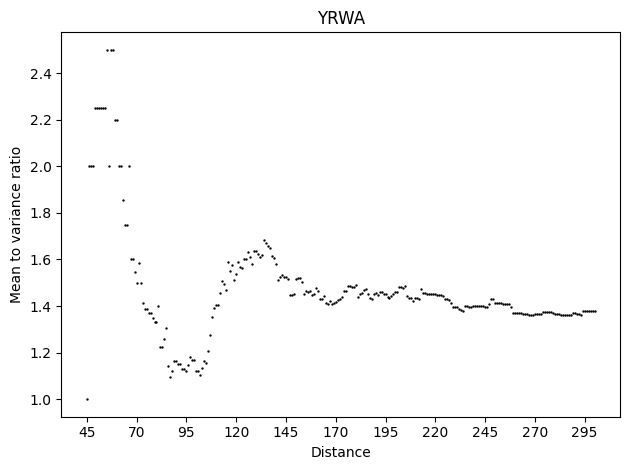

In [96]:
# Plotting
# OSFL_mean_var_df['ratio'].plot(kind='scatter')
plt.scatter(x = range(len(YRWA_mean_var_df.index)), 
            y = YRWA_mean_var_df['ratio'],
            s=0.5,
            c = 'black'
)

# Customizing the plot with fewer x-ticks and rotated labels
tick_spacing = 25  # Adjust this value as needed to reduce clutter
plt.xticks(range(0, len(YRWA_mean_var_df.index), tick_spacing), YRWA_mean_var_df.index[::tick_spacing], rotation=0)  # Rotate labels and use every 10th label

plt.title('YRWA')
plt.ylabel('Mean to variance ratio')
plt.xlabel('Distance')
plt.tight_layout()  # Adjust layout to make room for the rotated x-tick labels
plt.savefig(os.path.join(mean_var_figure_path, 'YRWA_M2V plot.png'))


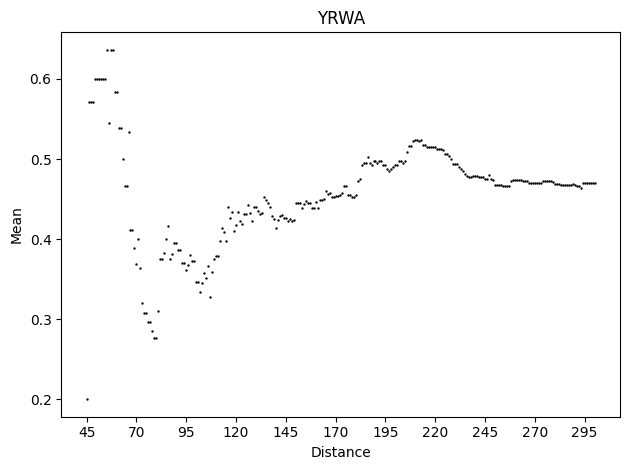

In [97]:
# Plotting
# OSFL_mean_var_df['ratio'].plot(kind='scatter')
plt.scatter(x = range(len(YRWA_mean_var_df.index)), 
            y = YRWA_mean_var_df['mean'],
            s=0.5,
            c = 'black'
)

# Customizing the plot with fewer x-ticks and rotated labels
tick_spacing = 25  # Adjust this value as needed to reduce clutter
plt.xticks(range(0, len(YRWA_mean_var_df.index), tick_spacing), YRWA_mean_var_df.index[::tick_spacing], rotation=0)  # Rotate labels and use every 10th label

plt.title('YRWA')
plt.ylabel('Mean')
plt.xlabel('Distance')
plt.tight_layout()  # Adjust layout to make room for the rotated x-tick labels
# plt.savefig(os.path.join(mean_var_figure_path, 'YRWA_M2V plot.png'))


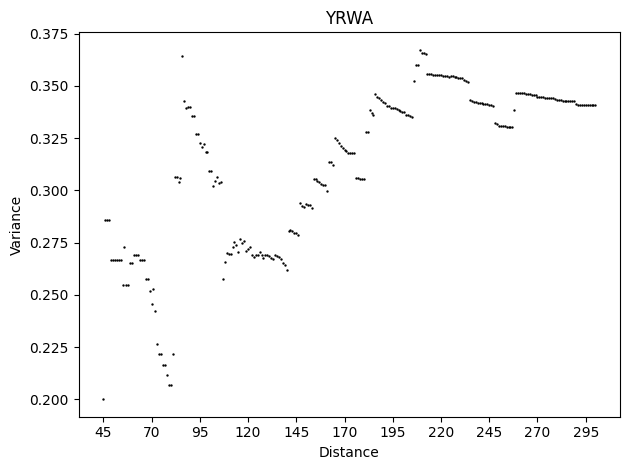

In [98]:
# Plotting
# OSFL_mean_var_df['ratio'].plot(kind='scatter')
plt.scatter(x = range(len(YRWA_mean_var_df.index)), 
            y = YRWA_mean_var_df['variance'],
            s=0.5,
            c = 'black'
)

# Customizing the plot with fewer x-ticks and rotated labels
tick_spacing = 25  # Adjust this value as needed to reduce clutter
plt.xticks(range(0, len(YRWA_mean_var_df.index), tick_spacing), YRWA_mean_var_df.index[::tick_spacing], rotation=0)  # Rotate labels and use every 10th label

plt.title('YRWA')
plt.ylabel('Variance')
plt.xlabel('Distance')
plt.tight_layout()  # Adjust layout to make room for the rotated x-tick labels
# plt.savefig(os.path.join(mean_var_figure_path, 'YRWA_M2V plot.png'))


# B. Detection probailities

$$
P_{\text{detection}}(site) = \frac{N_{\text{visits with detections}}}{N_{\text{total visits}}}
$$

$$P_{\text{average detection}} = \frac{\sum_{i=1}^{n} P_{\text{detection}}(site_i)}{n}$$

In [1]:
# Reading the obs_count_10.csv file
obs_count_10 = truncCounts150_10vis
# obs_count_10 = truncCounts250_10vis
# obs_count_10 = unlimitedCounts_10vis
# Filter out sites with less than 10 visits
sites_with_10_or_more_visits = obs_count_10['location'].value_counts() >= 10
sites_to_consider = sites_with_10_or_more_visits[sites_with_10_or_more_visits].index

filtered_obs_count = obs_count_10[obs_count_10['location'].isin(sites_to_consider)]
# For each site, calculate the detection probability
site_list = list(filtered_obs_count['location'].unique())
# detection_probs = len(site_list)
# detection_probs = {}
detection_probs = []
bird = 'OSFL'
for site in site_list:
    total_visits = filtered_obs_count.loc[filtered_obs_count['location'] == site].shape[0]
    # print(total_visits)
    detection_visits = filtered_obs_count.loc[filtered_obs_count['location'] == site].loc[filtered_obs_count[bird] >= 1].shape[0]
    # print(detection_visits)
    detection_probs.append(detection_visits/total_visits)
# print(detection_probs)
average_detection_prob = sum(detection_probs)/len(detection_probs)
print(average_detection_prob)
    

NameError: name 'truncCounts150_10vis' is not defined

In [ ]:
p = average_detection_prob
d = 0.1
def required_visits(p, d):
    return math.ceil(math.log(d) / math.log(1-p))

In [ ]:
visits = required_visits(p, d)
print(visits)